In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('names.txt', 'r').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [3]:
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [4]:
block_size = 3

def build_dataset(words):
    X, Y = [], []

    for w in words:
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])
    

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [45]:
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(123456789)
C = torch.randn((vocab_size, n_embd),                  generator=g)
W1 = torch.randn((n_embd * block_size, n_hidden),      generator=g) * 0.2
b1 = torch.randn((n_hidden),                           generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size),               generator=g) * 0.01
b2 = torch.randn((vocab_size),                         generator=g) * 0

parameters = [C, W1, b1, W2, b2]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

11897


In [49]:
max_step = 200000
batch_size = 32
lossi = []

for i in range(max_step):

    ix = torch.randint(0, Xtr.shape[0], (batch_size,), generator=g)
    Xb, Yb = Xtr[ix], Ytr[ix]

    emb = C[Xb]
    embcat = emb.view(emb.shape[0], -1)
    hpreact = embcat @ W1 + b1
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)

    for p in parameters:
        p.grad = None
    loss.backward()

    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    if i % 10000 == 0:
        print(f"{i:7d}/{max_step:7d} : {loss.item():.4f}") 
    lossi.append(loss.log10().item())
    

      0/ 200000 : 3.2466
  10000/ 200000 : 2.3288
  20000/ 200000 : 2.3351
  30000/ 200000 : 1.7953
  40000/ 200000 : 2.1212
  50000/ 200000 : 2.0273
  60000/ 200000 : 2.0501
  70000/ 200000 : 1.7782
  80000/ 200000 : 1.7407
  90000/ 200000 : 1.9257
 100000/ 200000 : 1.5783
 110000/ 200000 : 2.0503
 120000/ 200000 : 2.1109
 130000/ 200000 : 1.9464
 140000/ 200000 : 2.1028
 150000/ 200000 : 1.8667
 160000/ 200000 : 1.7909
 170000/ 200000 : 2.0087
 180000/ 200000 : 2.5142
 190000/ 200000 : 2.2861


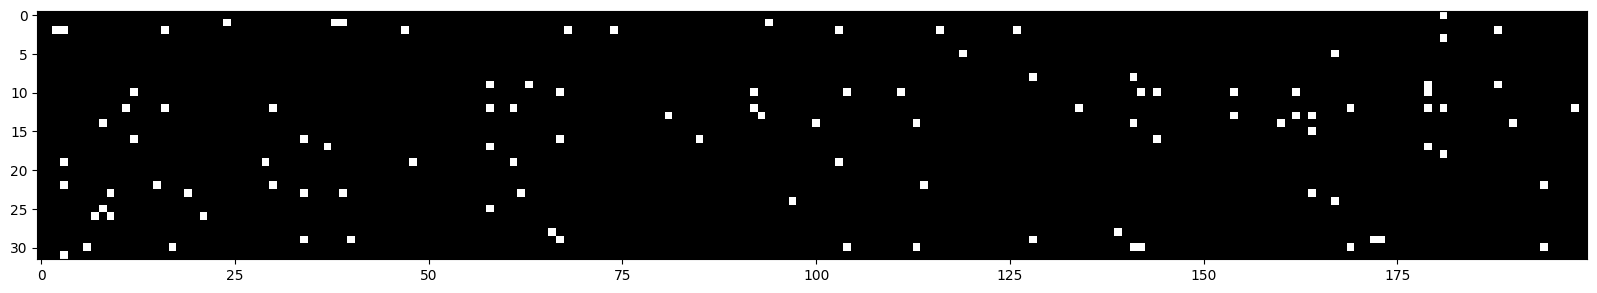

In [47]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

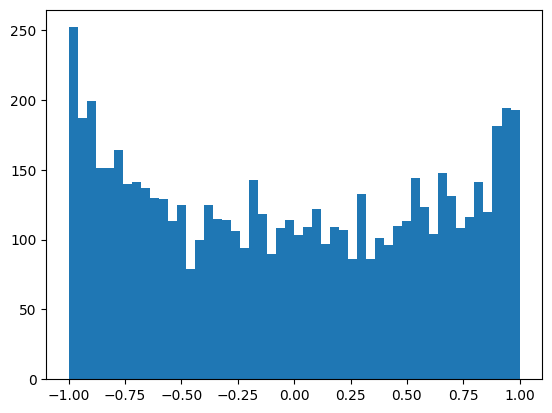

In [48]:
plt.hist(h.view(-1).tolist(), 50)
plt.show()

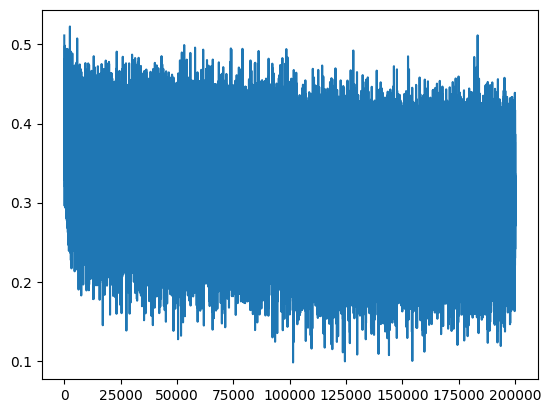

In [50]:
plt.plot(lossi)

In [51]:
@torch.no_grad()
def split_loss(split):
    x, y = {
        'train': (Xtr, Ytr),
        'val': (Xdev, Ydev),
        'test': (Xte, Yte)
    }[split]
    emb = C[x]
    embcat = emb.view(emb.shape[0], -1)
    h = torch.tanh(embcat @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.0373175144195557
val 2.10421085357666


In [52]:
g = torch.Generator().manual_seed(12345678 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        emb = C[torch.tensor([context])]
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

alap.
haddy.
xyonaadhitoreena.
per.
kahagiocton.
adani.
isa.
tell.
marie.
ari.
ejlanith.
abdahli.
dolibreamyzlee.
sivaan.
jayelynni.
melle.
jondro.
kenzonnoni.
kiya.
anayden.
